In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import os
from scipy.io import wavfile
#import torch
#import torch.nn as nn
#import torch.optim as optim
import pickle
from IPython.display import clear_output
from IPython.core.debugger import set_trace
from scipy.io import wavfile
#from torch.utils.data import DataLoader
from pathlib import Path
#from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
#from speechpy.feature import mfcc
from datetime import datetime
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()

from pandas.io.json import json_normalize

## Visualizations

In [4]:
def augment_data(loss,N):
    """
    create additional fake data similar to loss with gaussian noise
    """
    return np.abs((np.random.normal(0,0.0003,[N,23]) + loss).T)

In [281]:
def get_inputs_linreg(losses):
    """
    return the x y necessary to fit a linear regression
    
    Args:
        losses (list of list of int): all nested lists don't necessarily have the same shape because of early stopping: list of the metric for a given
        combination of hyperparameters
        
    Returns:
        X,y (np.array): data fitted for the input of Linear Regression fitter
    """
    losses = np.asarray(losses)
    X = [np.arange(len(run))+1 for run in losses]
    X = np.concatenate(X,axis=None)
    X = np.expand_dims(X,axis = 1)
    #X = np.expand_dims(X.flatten(),axis = 1)
    y = np.concatenate(losses,axis=None)
    return X,y

In [424]:
def plot_losses_fits(losses,axes,colors,title=""):
    """
    Plot the fitted both on loglog and linear plots on top of the data.
    
    Args:
        losses(np.array of float): M X N_epochs with M the number of runs in the CV for the given parameter
        colors
    """
    # color 1 for the losses, color 2 for the fit
    color1,color2 = colors
    lin_ax = axes[0]
    log_ax = axes[1]
    
    lin_ax.set_yscale('log')
    log_ax.set_yscale('log')
    log_ax.set_xscale('log')
    
    # we set the limit of the plot to the longest run
    max_n_epochs = max(len(run) for run in losses)
    
    mean_loss = []
    for i in range(max_n_epochs):
        presents = []
        for run in losses:
            # in solid line
            if (i < len(run)):
                presents.append(run[i])
        mean_loss.append(np.mean(presents))
    x_mean = np.expand_dims(np.arange(max_n_epochs)+1,axis=1)
    
    # we recreate the epochs
    x,y = get_inputs_linreg(losses)
    x_mean_log = np.log(x_mean)
    y_log = np.log(y)
    x_log = np.log(x)
    
    # the regression works in the logspace
    reg = LinearRegression().fit(x_log,y_log)
    score = reg.score(x_log,y_log)
    y_pred_log = reg.predict(x_mean_log)
    
    # we recover the equivalent on a linear scale
    y_pred  = np.exp(y_pred_log)
    

    # plot the empirical curves
    lin_ax.set_title("Linear plot of the loss")
    lin_ax.set_xlabel("Epochs")
    lin_ax.set_ylabel("Cross Entropy Loss")
    
    for loss in losses:
        lin_ax.plot(np.arange(len(loss))+1,loss,color=color1,alpha=0.2)
    lin_ax.plot(x_mean,mean_loss,color=color1,label='mean_runs {}'.format(title))
    lin_ax.plot(x_mean,y_pred,color=color2,label='fitted exp curve {}'.format(title))
    lin_ax.legend()
    
    for loss in losses:
        log_ax.plot(np.arange(len(loss))+1,loss,color=color1,alpha=0.2)
    log_ax.plot(x_mean,mean_loss,color=color1,label='mean_runs {}'.format(title))
    log_ax.plot(x_mean,y_pred,color=color2,label='fitted exp curve {}'.format(title))
    log_ax.legend()

    log_ax.set_title("Logarithmic plot of the loss")
    log_ax.set_xlabel("Epochs")
    log_ax.set_ylabel("Cross Entropy Loss")
 
    return reg

In [387]:
df = pd.read_json("./log/log_images_results.json")
df.drop([4,14,9],inplace=True)

0.46623954558934666

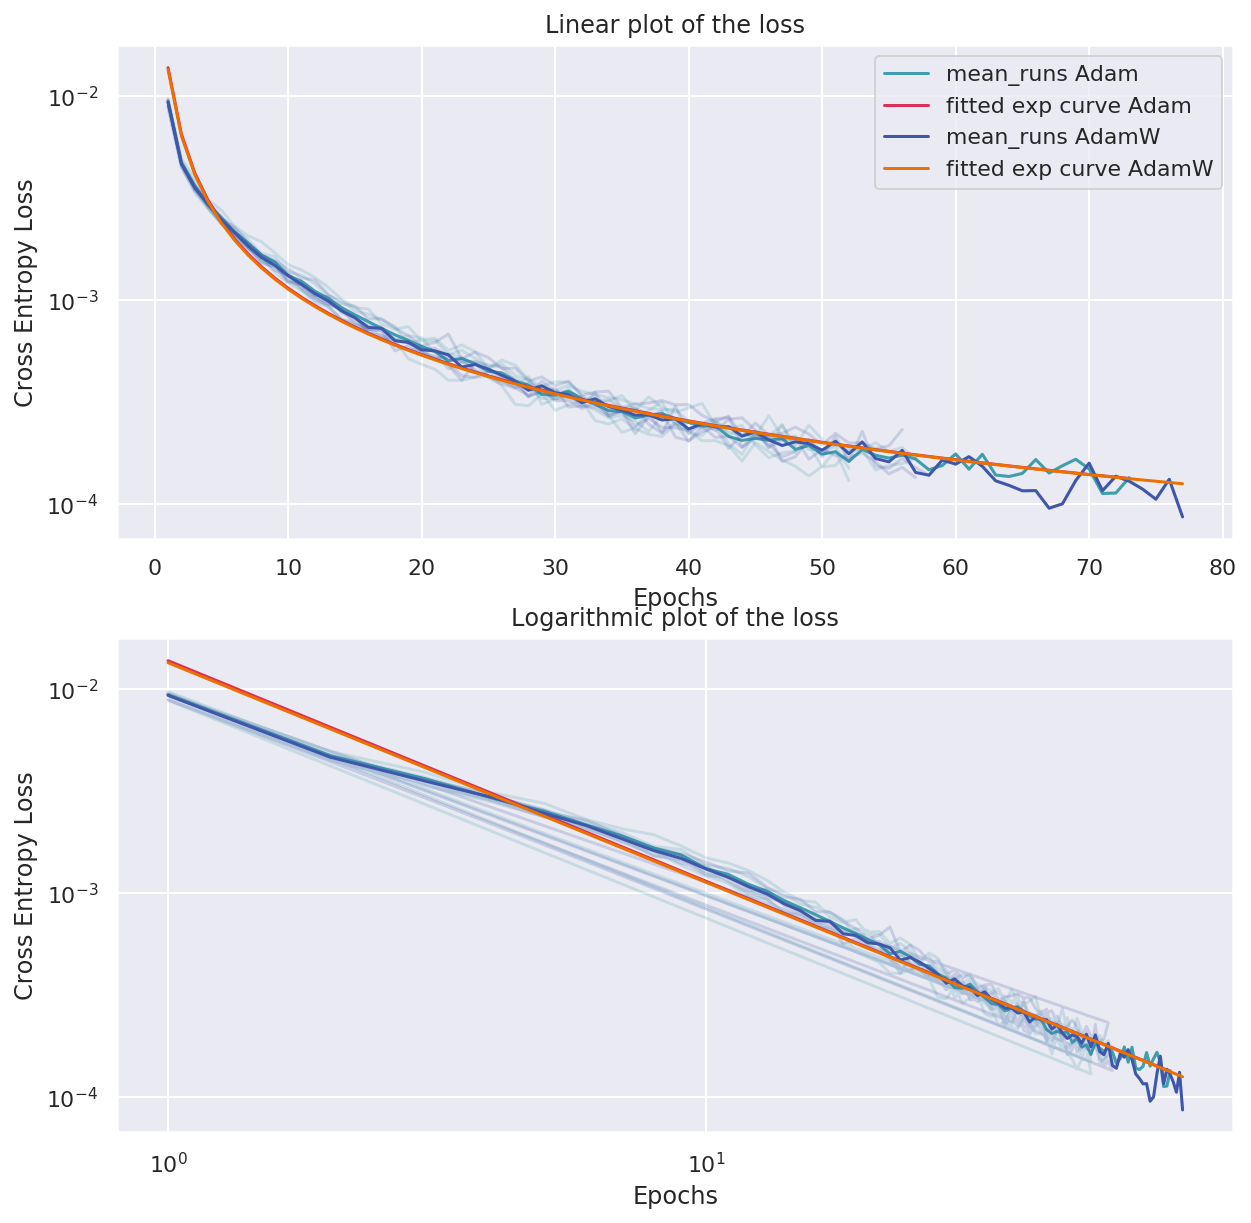

In [388]:
# which run we take
# TODO: if we compute equal gridsearch, we can increase index at sth >0
index = 0
adam = df[df.optimizer == 'Adam'].iloc[index]

param = adam.param
adamw = df[(df.optimizer == 'AdamW') & (df.param == param)].iloc[0]

fig, axes = plt.subplots(2, figsize=(10, 10))
col1 = ("#3e9eab", "#db2e59")
reg1 = plot_losses_fits(adam.train_losses, axes, col1,title="Adam")
col2 = ("#3e57ab", "#ed7002")
reg2 = plot_losses_fits(adamw.train_losses, axes, col2,title="AdamW")

x_adam, y_adam= get_inputs_linreg(adam.train_losses)
x_adamw, y_adamw = get_inputs_linreg(adamw.train_losses)
student_test(x_adam,y_adam,x_adamw,y_adamw)

Text(0, 0.5, 'Training Loss (Cross Entropy)')

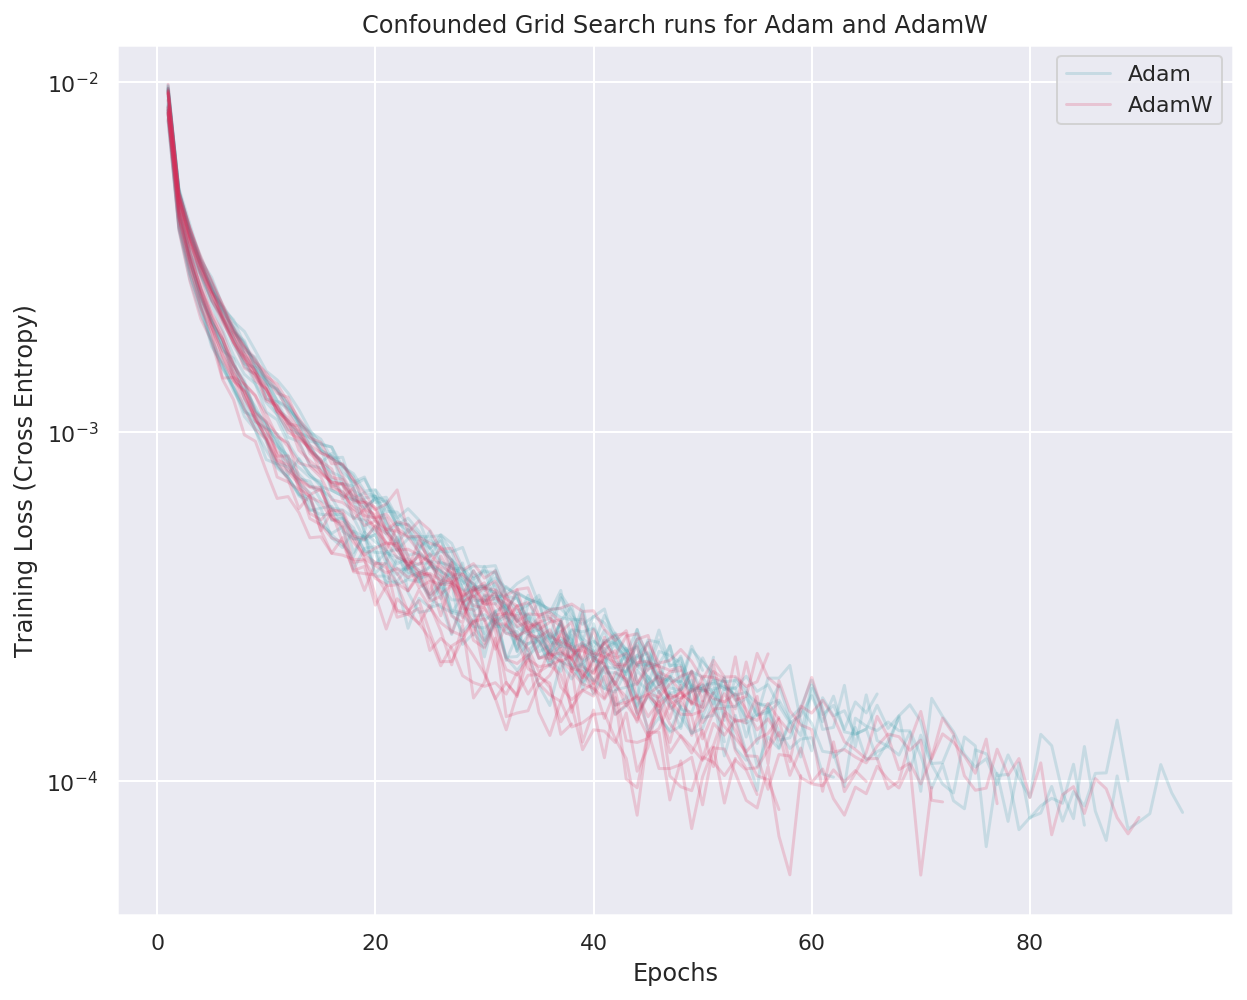

In [389]:
fig, ax = plt.subplots(1, figsize=(10, 8))
coladam = "#3e9eab"
coladamw = "#db2e59"
adam_df = df[df.optimizer == 'Adam']
adamw_df = df[df.optimizer == 'AdamW']
def plot_df(df,color,label):
    for i,(_,row) in enumerate(df.iterrows()):
        losses = row.train_losses
        for j,loss in enumerate(losses):
            if (not isinstance(loss,float)):
                ax.plot(np.arange(len(loss))+1,loss,color=color,alpha=0.2,label=label if j== 0 and i==0 else None )
plot_df(adam_df,color=coladam,label='Adam')
plot_df(adamw_df,color=coladamw,label='AdamW')
ax.set_yscale('log')
ax.legend()
ax.set_title("Confounded Grid Search runs for Adam and AdamW")
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss (Cross Entropy)')

(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56969e29d0>,
       dtype=object))

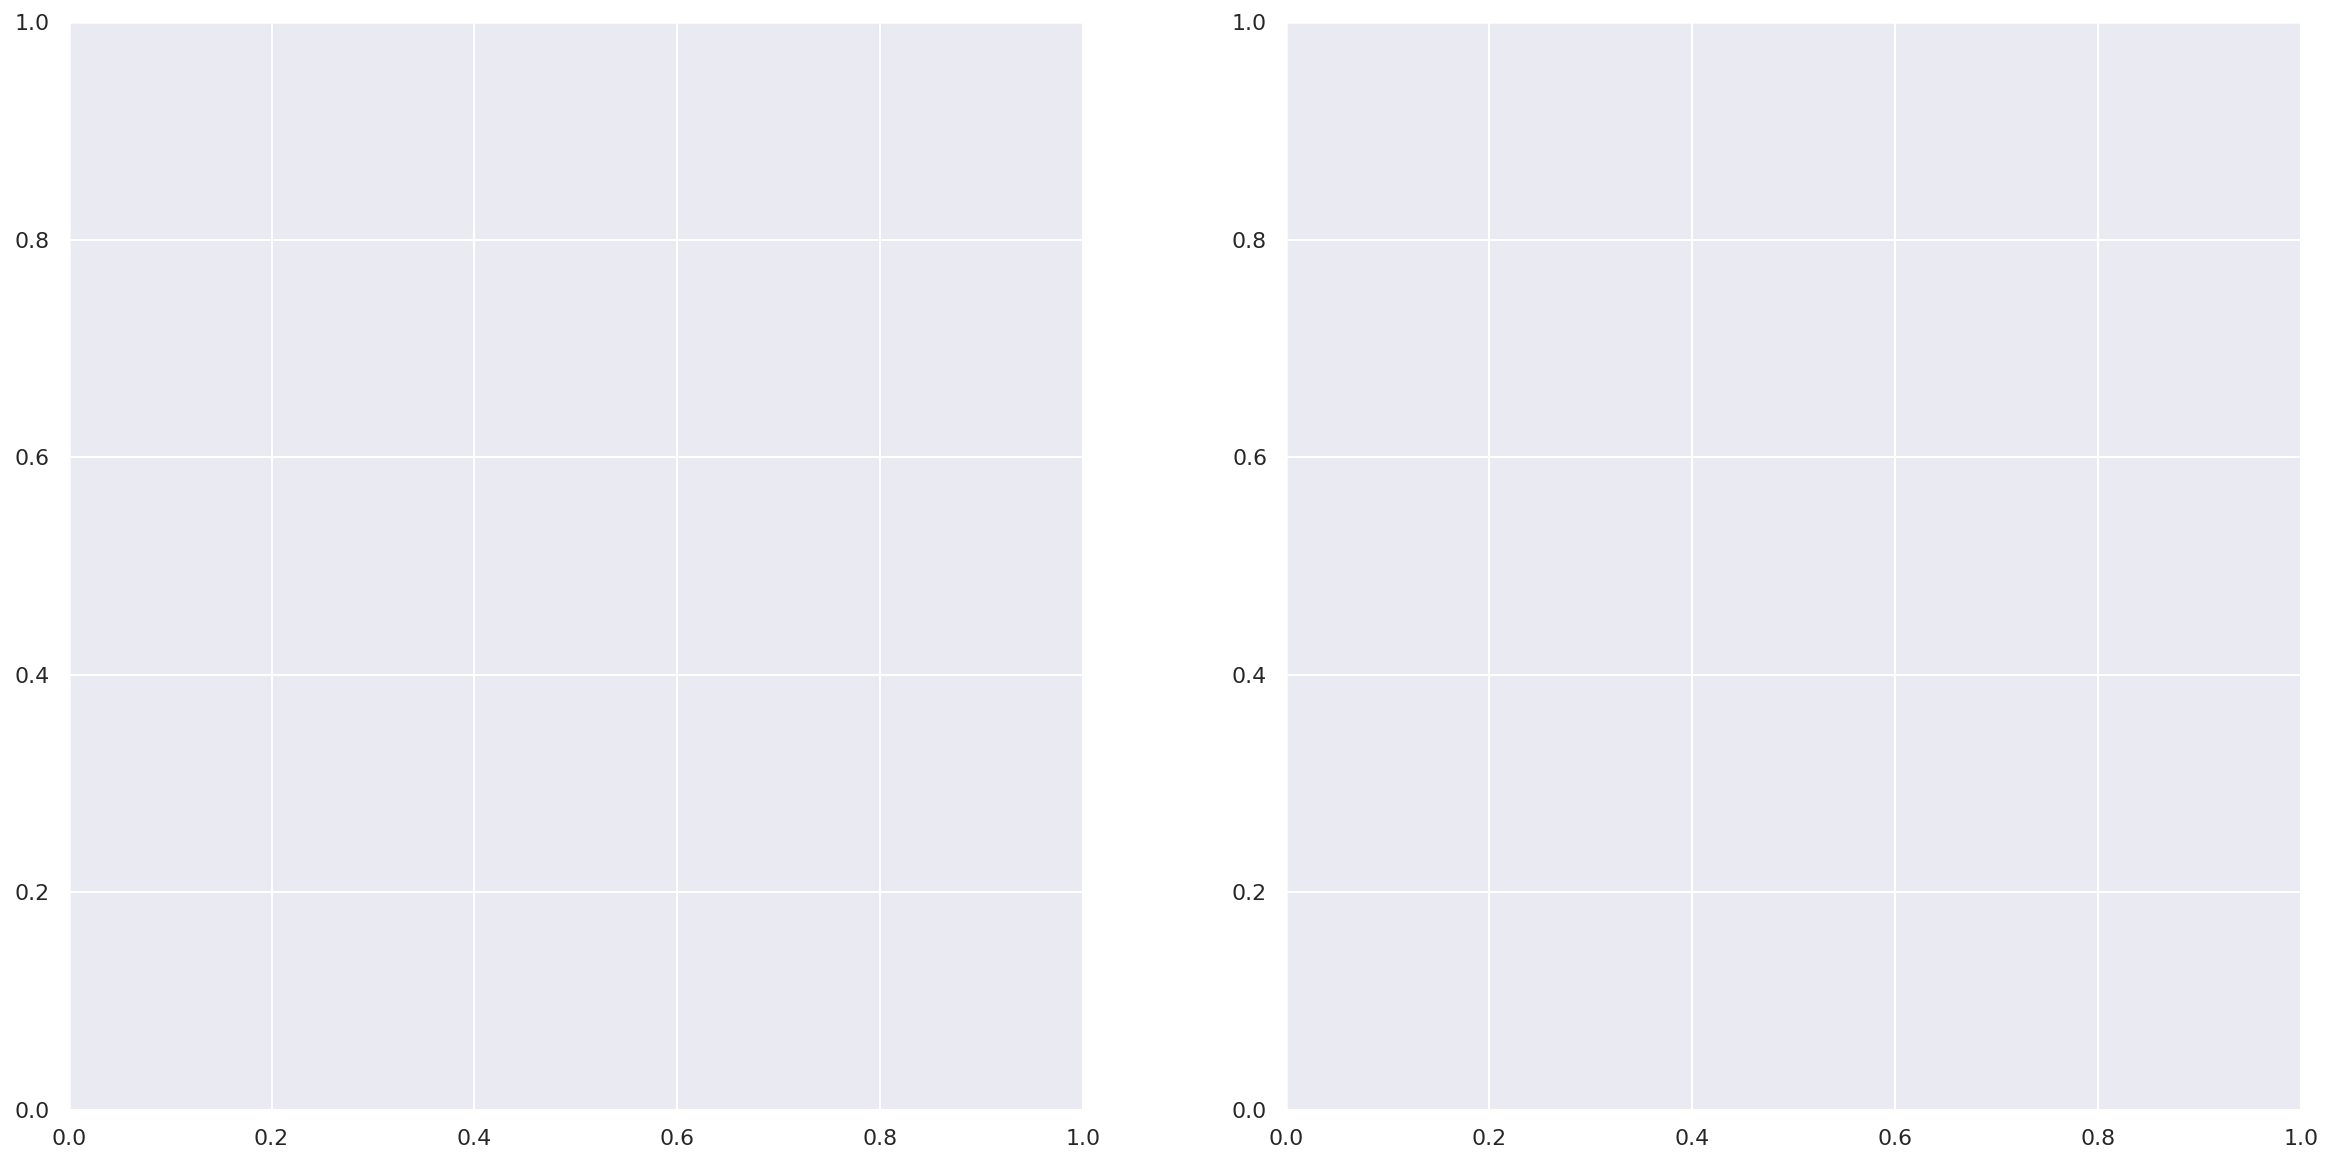

In [405]:
plt.subplots(1,2, figsize=(20, 10))

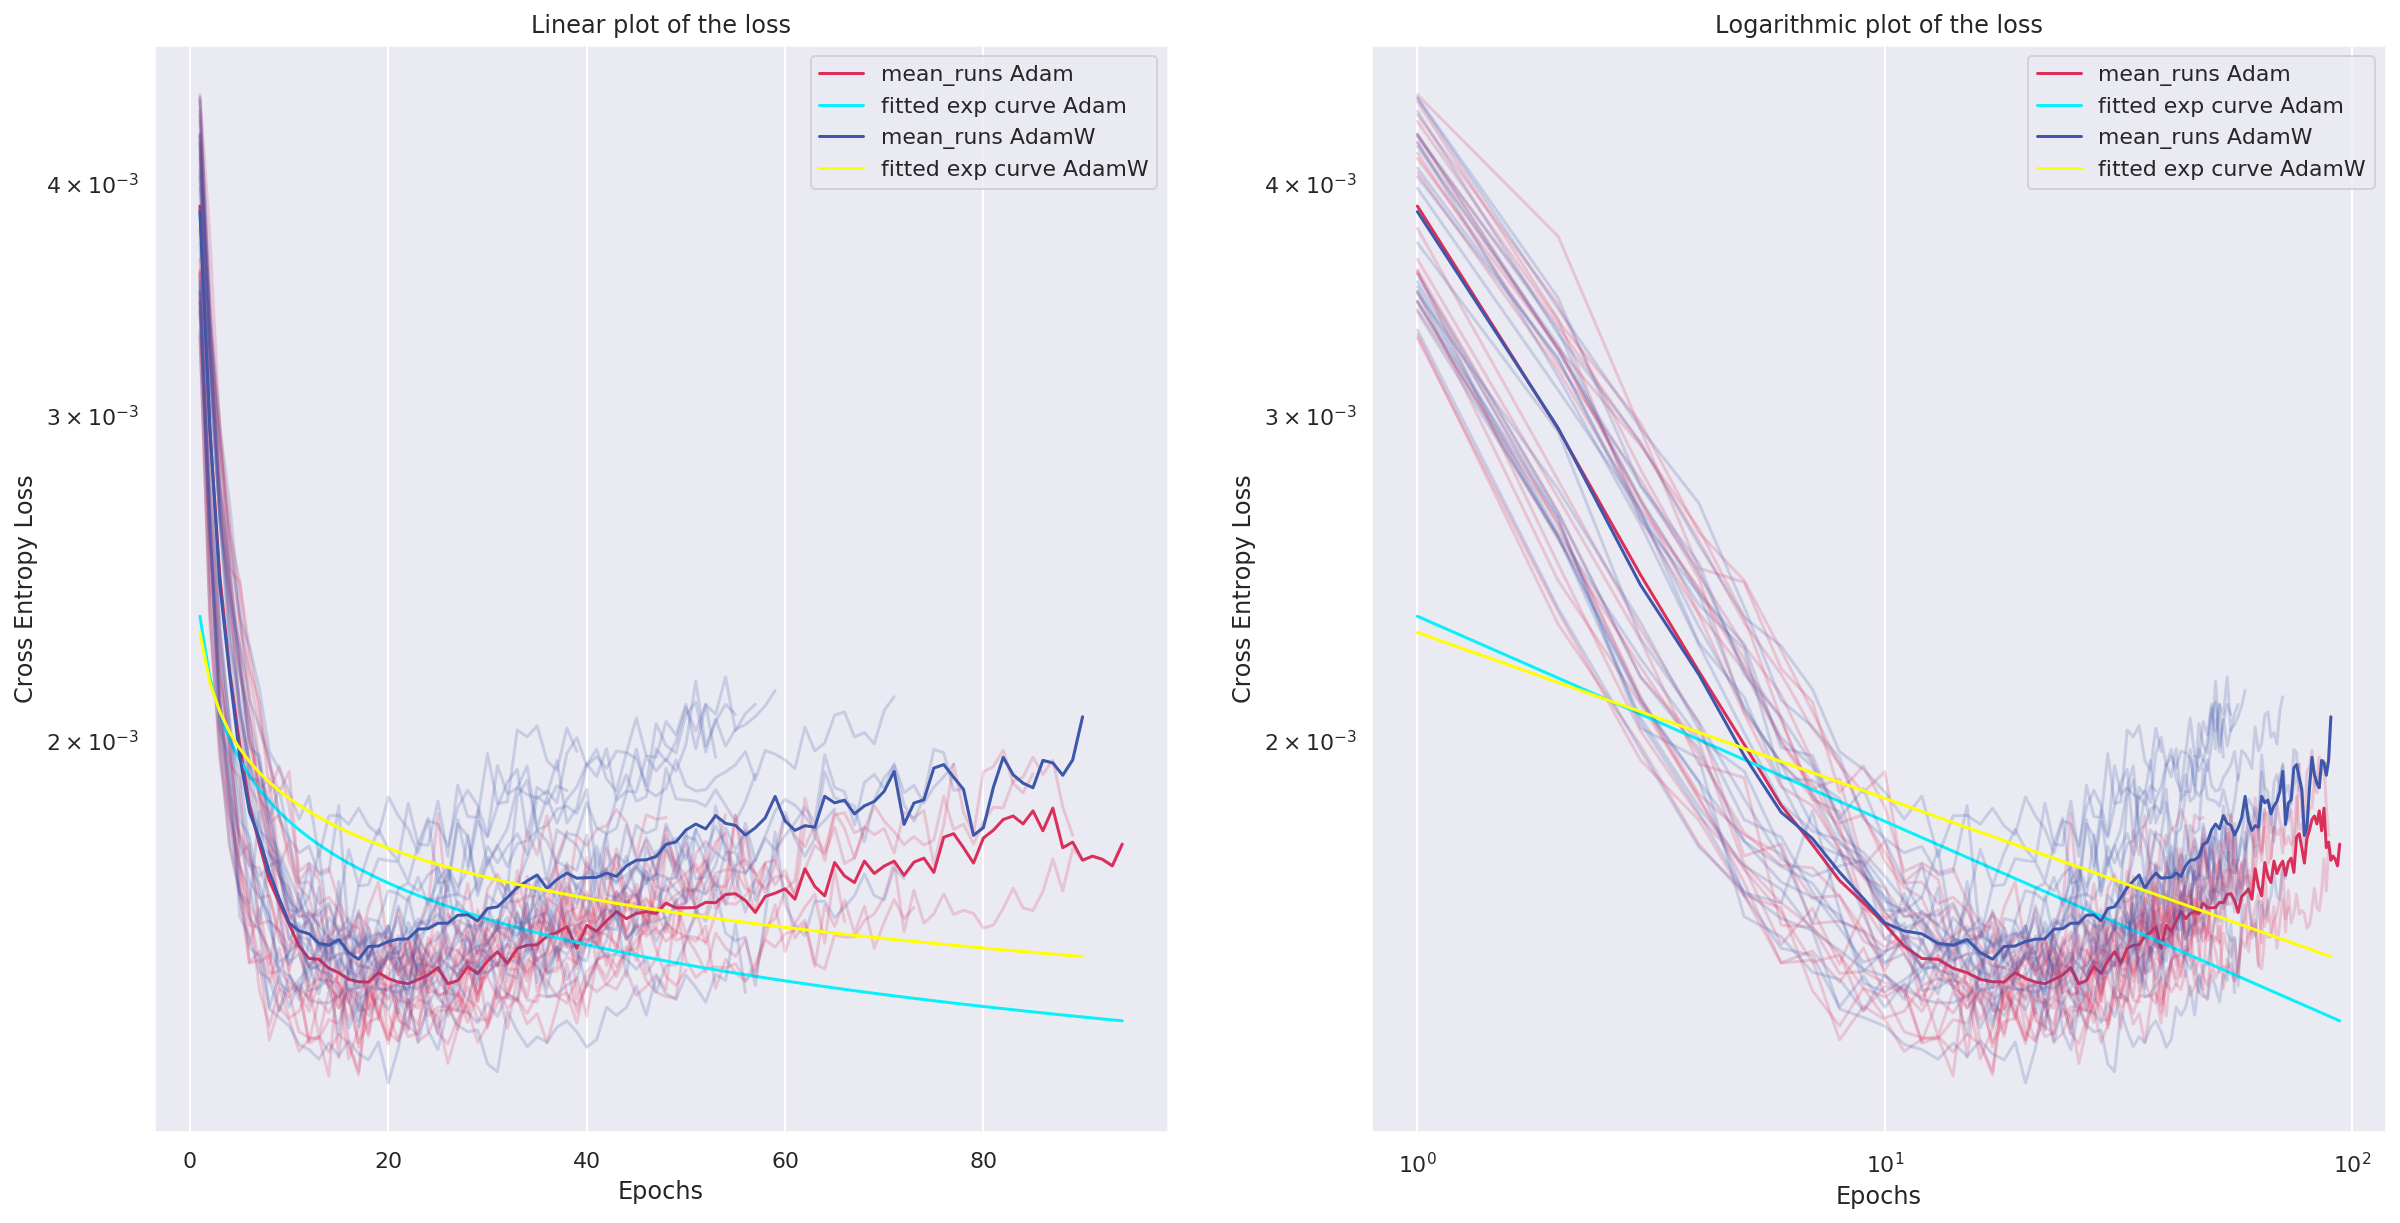

In [425]:
adam_df = df[df.optimizer == 'Adam']
adamw_df = df[df.optimizer == 'AdamW']

adam_concat_losses = []
for losses in adam_df.val_losses.values:
    adam_concat_losses = adam_concat_losses + losses

adamw_concat_losses = []
for losses in adamw_df.val_losses.values:
    adamw_concat_losses = adamw_concat_losses + losses
    
fig, axes = plt.subplots(1,2, figsize=(20, 10))


col1 = ("#db2e59","#08f0fc")
reg1 = plot_losses_fits(adam_concat_losses, axes.flatten(), col1,title="Adam")
col2 = ("#3e57ab", "yellow")
reg2 = plot_losses_fits(adamw_concat_losses, axes.flatten(), col2,title="AdamW")

In [421]:
x_adam, y_adam= get_inputs_linreg(adam_concat_losses)
x_adamw, y_adamw = get_inputs_linreg(adamw_concat_losses)
student_test(x_adam,y_adam,x_adamw,y_adamw)

0.1338584883423577

## Statistics test

In [7]:
def student_test(x1,y1,x2,y2,verbose=False):
    y1 = y1.flatten()
    y2 = y2.flatten()
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    l1 = LinearRegression().fit(x1,y1)
    l2 = LinearRegression().fit(x2,y2)
    
    # coeffs for the linear regressions
    b1 = l1.coef_[0]
    b2 = l2.coef_[0]

    pred1 = l1.predict(x1)
    pred2 = l2.predict(x2)

    def steyx(x,y):
        """ get the standard deviation for the regression"""
        x = x.flatten()
        n = x.shape[0]
        a = 1/(n-2)
        b = np.std(y)**2*n
        c = (np.cov(x,y)[0,1]*(n-1))**2
        d = np.std(x)**2*n
        return np.sqrt(a*(b-c/d))
    
    stey1 = steyx(x1,y1)
    stey2 = steyx(x2,y2)

    def gets(x,ste):
        """ get the standard deviation for the slopes"""
        n = x.shape[0]
        return ste/np.sqrt(np.std(x)**2*(n))

    s1 = gets(x1,stey1)
    s2 = gets(x2,stey2)

    diff = np.abs(b2 - b1)
    
    # pythagore relation
    sediff = np.sqrt(s1**2+s2**2)

    df = n1 + n2 - 4

    # t statistic
    t = diff/sediff

    # 2-tailed test
    p = 2*(1 - stats.t.cdf(t,df=df))
    if verbose:
        print(f"b1:{b1}")
        print(f"b2:{b2}")
        print("stey1:",stey1)
        print("stey2:",stey2)
        print("b1-b2:",diff)
        print("sediff:",sediff)
        print("t:",t)
        
    return p

In [8]:
x1 = np.log(np.arange(fake_losses.shape[0])+1)
x2  = np.log(np.arange(fake_losses.shape[0])+1)

X1 = np.repeat(x1,fake_losses.shape[1])
X2 = np.repeat(x2,fake_losses2.shape[1])
X1 = np.expand_dims(X1,axis=1)
X2 = np.expand_dims(X2,axis=1)

y1 = np.reshape(np.log(fake_losses),(fake_losses.shape[0]*fake_losses.shape[1],1))
y2 = np.reshape(np.log(fake_losses2),(fake_losses2.shape[0]*fake_losses2.shape[1],1))

In [9]:
student_test(X1,y1,X2,y2)

3.0207592986997156e-06

b1:10.446509613051834
b2:0.7493587784122165
stey1: 0.534449511533488
stey2: 2.0552198929338066
b1-b2: 9.697150834639617
sediff: 1.5015933352091757
t: 6.457907482180439


0.02314883721661687

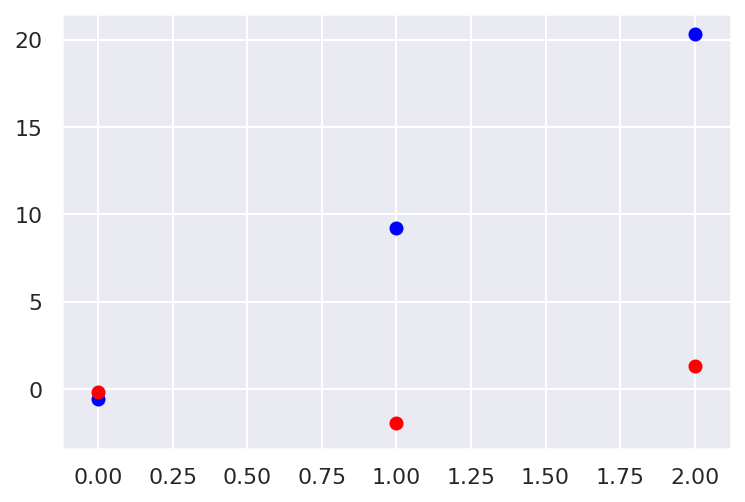

In [97]:
# test example for the student 
X1 = np.arange(3) 
X1 = np.expand_dims(X1,axis=1)
y1 = (10* X1 + np.random.normal(0,1,X1.shape)).flatten() 
y2 = (0.1*X1 + np.random.normal(0,1,X1.shape)).flatten()

plt.scatter(X1,y1,color='blue')
plt.scatter(X1,y2,color='red')
student_test(X1,y1,X1,y2,True)